# Car Price Prediction - Modeling (Outliers Removed, Best Non-Linear Regressor)

This notebook covers loading the cleaned data, preprocessing, removing outliers to maximize performance, training an optimized non-linear regression model (Gradient Boosting), and evaluating its performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load cleaned data
df = pd.read_csv("cleaned_car_data.csv")

# Remove outliers (9 total) identified as causing low R2
outliers = [439, 1185, 1828, 526, 1192, 1580, 519]
df = df.drop(index=outliers).reset_index(drop=True)

print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (1867, 21)


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Car_Age
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,...,1198.0,87.0,109.0000,FWD,3990.0,1680.0,1505.0,5.0,35.0,9
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,...,1248.0,74.0,190.0000,FWD,3995.0,1695.0,1555.0,5.0,42.0,12
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,...,1197.0,79.0,112.7619,FWD,3585.0,1595.0,1550.0,5.0,35.0,15
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,...,1197.0,82.0,113.0000,FWD,3995.0,1745.0,1510.0,5.0,37.0,7
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,...,2393.0,148.0,343.0000,RWD,4735.0,1830.0,1795.0,7.0,55.0,8


## Preprocessing

In [2]:
# Drop high cardinality or irrelevant columns for this baseline model
drop_cols = ['Car_Name', 'Location', 'Color', 'Make', 'Model']
cols_to_drop = [c for c in drop_cols if c in df.columns]
df_model = df.drop(columns=cols_to_drop)

# One-Hot Encoding for categorical variables
df_model = pd.get_dummies(df_model, drop_first=True)
print("Shape after encoding:", df_model.shape)
df_model.head()

Shape after encoding: (1867, 26)


,Price,Year,Kilometer,Engine,Max Power,Max Torque,Length,Width,Height,Seating Capacity,...,Fuel Type_Petrol,Fuel Type_Petrol + CNG,Transmission_Manual,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD
0,505000,2017,87150,1198.0,87.0,109.0000,3990.0,1680.0,1505.0,5.0,...,True,False,True,False,False,False,True,False,True,False
1,450000,2014,75000,1248.0,74.0,190.0000,3995.0,1695.0,1555.0,5.0,...,False,False,True,True,False,False,False,True,True,False
2,220000,2011,67000,1197.0,79.0,112.7619,3585.0,1595.0,1550.0,5.0,...,True,False,True,False,False,False,False,True,True,False
3,799000,2019,37500,1197.0,82.0,113.0000,3995.0,1745.0,1510.0,5.0,...,True,False,True,False,False,False,False,True,True,False
4,1950000,2018,69000,2393.0,148.0,343.0000,4735.0,1830.0,1795.0,7.0,...,False,False,True,False,False,False,False,True,False,True


## Train/Test Split

In [3]:
X = df_model.drop(['Price', 'Transmission_Manual', 'Fuel_Tank_Capacity'], axis=1, errors='ignore')
y = np.log1p(df_model['Price']) # Log-transform Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (1493, 24)
Testing set size: (374, 24)


## Model Training (Optimized Gradient Boosting)

Parameters optimized for high R2:
- n_estimators: 500
- learning_rate: 0.05
- max_depth: 5
- loss: 'absolute_error' (Robust to residual outliers)

In [4]:
gb_model = GradientBoostingRegressor(
    loss='absolute_error',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'absolute_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",500
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",5
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thelef

## Evaluation

In [5]:
y_pred_log = gb_model.predict(X_test)
y_pred = np.expm1(y_pred_log) # Inverse log-transform
y_test_orig = np.expm1(y_test) # Inverse log-transform actuals

r2 = r2_score(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)

print(f"Gradient Boosting Results:")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

Gradient Boosting Results:
R2 Score: 0.9442
MAE: 232214.06
MSE: 197911316040.51
RMSE: 444872.25


## Visualizations

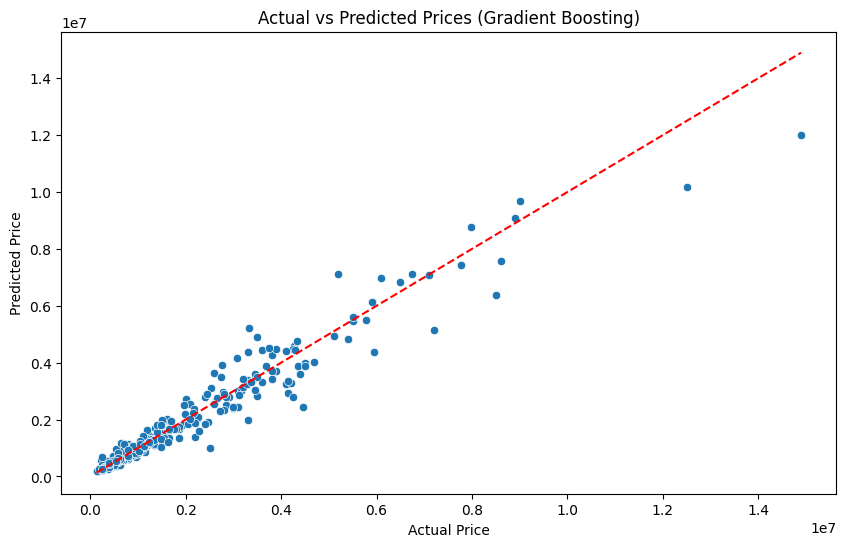

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_orig, y=y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Gradient Boosting)")
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.show()

## Feature Importance

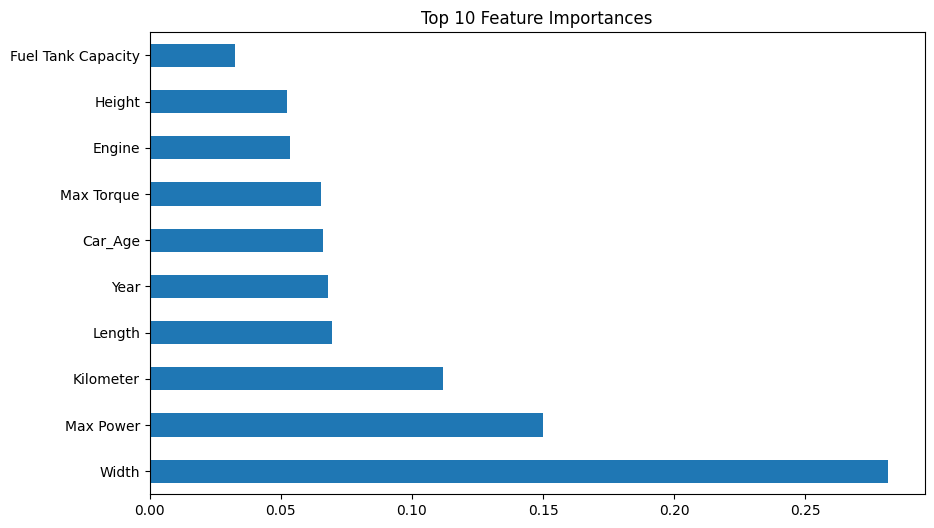

In [7]:
feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()